# Pulse-Based Large Variational Quantum Algorithm for Combinatorial Optimization Problems - Initial Draft

## Motivation

Consider the case of an NP-Hard combinatorial optimization problem-instance of huge scale. Obviously, (exactly) solving a problem like this is infeasible. Yet, classical state-of-the-art heursitic algorithms can provide approximated solutions for NP-Hard combinatorial optimization problems - among them some algorithms are both efficient and provide high-quality approximations.

However, we can consider the scale of problem-instances which is too large to be even stored on a classical computer - i.e. the scale of above $\approx 2^{50}$ problem-variables. Regarding this order of scale, we can ask:

1. Are there huge problem-instances that can be produced efficiently in an online manner, that overcomes the main memory obstacle of the very need to save the problem-instance?

2. Are (some) classical approximation algorithms capable of functioning with an online generation of the problem-instance?

3. Once we obtain an approximated solution, can we benchmark its quality efficiently?

4. Can we come up with a quantum algorithm setting that can be benificial for this type of problem setting?

------------

## MaxCut

For now, we focus on MaxCut, because we know this problem pretty well, and because of its centrality in the landscape of combinatorial optimization problems:

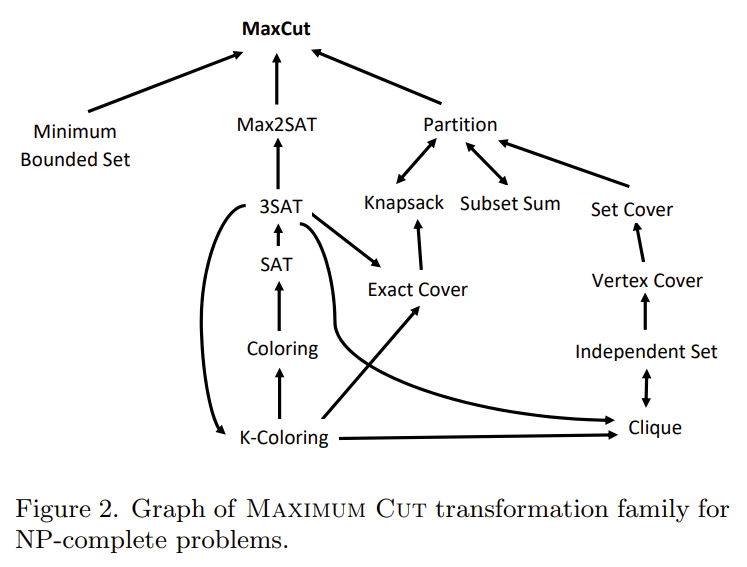

*Taken from [[1]](#References).

-----

## 1. Online Generation of Graphs

A simple example of an online graph-generation would be using simple modular arithmetic. Consider the group $\mathbb{Z}_n = \{0, 1, ..., N-1\}$ under the addition $\mod N$ action. Then, it is very easy to construct $d$-regular graphs with $N$ nodes on the fly, as demonstrated:

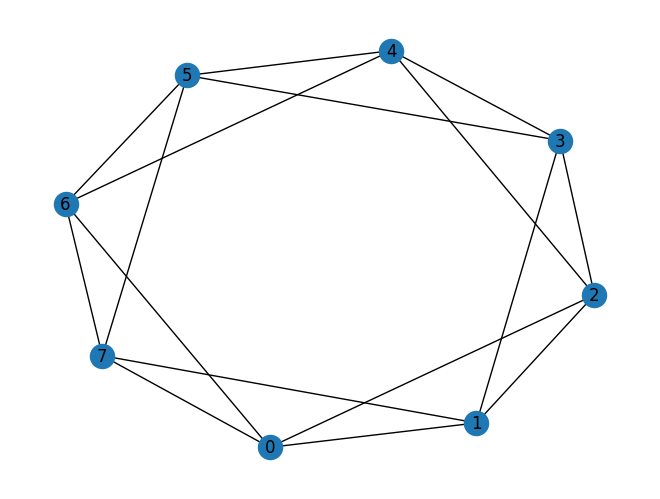

In [86]:
from typing import Optional

import numpy as np
import networkx as nx

def obtain_adjacent_nodes(
    node_id: int,
    N: Optional[int] = 8,
    plus: Optional[np.ndarray] = np.array([2, 7])
) -> np.ndarray:
    
    return (plus + node_id) % N

graph_def = {}
for node_id in range(8):
    graph_def[node_id] = obtain_adjacent_nodes(node_id)

graph = nx.Graph(graph_def)
nx.draw(graph, with_labels=True)

**TBD**:
1. Is this kind of graphs makes the solutions trivial?
2. Can we come up with more clever online graph-generation schemes?

------------

## 2. Classical Online Approximation Algorithms

I don't know if such algorithms exist, and if the current known algorithms are capable of handling problems in an online manner (maybe with little modifications?). **TBD**.

----------


## 3. Estimating the Quality of Approximated Solutions for Huge Problem-Instances

Regarding MaxCut, there is a simple method to assess the approximation ratio of a given cut, using the following lemma:

$$
    \text{MaxCut} = 2\ \mathbb{E}[X]
    \tag{Lemma 1}
$$

Where $X$ is the random variable that holds the cuts of random partitions. Or in other words, the expected value of many random partitions' cuts is half of the maximum cut. Computing a cut of a given partition takes $O(N^2)$ time, or $O(N)$ time in the case the graph at hand is regular with some constant degree. In addition, we need to think of the number of random partitions we have to check to obtain a sufficient precision for our MaxCut estimation, but let's assume for now we can do it efficiently (**TBD**).

However, we shall not forget that $n$ itself is a huge number. So even if our scheme is efficient in $n$, we should pay attention to the practical possibilty of executing the scheme. It might be the case that by massive parallelization this task indeed will be feasible. We should aim for number of nodes $n$ that are too big to be saved on memory, but still small enough so that classical computers will be able to perform of $O(N)$, or possibly $O(N^2)$ steps, in a feasible manner.

---------

## 4. Components of the Algorithm

### Ansatz

For now, we aim towards a pulsefied Ansatz composed of $n = \log_2(N)$ qubits, where every basis state denotes a partition of the graph's nodes into two disjoint subsets.

### Objective Function - Option 1 - QEMC Style

Let's assume, at least for now, that we measure the Ansatz in each repetition in the standard $Z$ basis, thus we obtain a bitstring (or a vectour of $\{+1, -1\}$ eigenvalues, if you like) upon each execution. Similar to the technique employed in the QEMC algorithm, this bitstring defines the partition of the graph into "blue" and "white" nodes, and we can employ also the QEMC's cost function:

$$
    C(G) = \sum_{(i, j) \in E'} \bigg( p_i + p_j - \frac{1}{B} \bigg)^2 + \bigg( |p_i - p_j| - \frac{1}{B} \bigg)^2
    \tag{1}
$$

Where:
* We assume $B = N / 2$.
* $E'$ is a subset of a chosen size $|E'|$, sampled at random, in a similiar heursitic manner as in the stochastic or mini-batch gradient descent algorithms.

**Note 1**: We could have iterate over the entire edge set $E$, and still our algorithm would have considered as efficient. However, since we aim for huge-scale graphs, I expect it's not going to be feasible in practice. Since we want to verify our ideas in experiment, and since there isn't an analytical way to prove anything here, the practical aspect is of very high importance.

**Note 2**: I hope that this kind of trick doesn't make the algorithm easy to simulate classically, but I won't be surprised if indeed we find out that this is the case.

**Note 3**: I don't know if this heuristic approach will work in our case. What are the reasons it works in machine learning? **TBD**.

**Note 4**: It is obvious that we will have only a small subset of the $N$ basis states of the Hilbert space sampled at each algorithm iteration, because $N = 2^n$ is a huge number. So $E'$ should contain the edges that are connected to the nodes that we do sample in each iteration. Hence the sampling of $E'$ out of $E$ occurs implicitly, when we sample basis states from the probabilioty distribution generated by the Ansatz.

### Objective Function - Option 2 - Cross-Entropy Google's Supreamcy [[2]](#References) Style

In some sense, we very much try to follow the path Google went when they executed their so-called quantum supremacy experiment [[2]](#References) - we aspire to prove better-than-random results on a problem size too large for classical memories. Google tried to do it for the most primitive task on would expect from a quantum (i.e, inherently probabilistic) computer - that is, sampling from (huge) probability distribution. We try to take one sep (or many steps?) further, and demonstrating better-than-random results for a useful, NP-Hard task.

In their experiment, Google tried to form unique, huge-scale probability distributions by employing a specific structure of a parameterized quantum circuit. However, due to noise, any circuit measured after enough gate-operations and execution time produce a uniform distribution. So they needed a tool to quantify how much a given probability distribution is different from another distribution (the uniform, random distribution in their case). To that end, they used a mathematical tool called cross-entropy benchmarking [[3]](#References):

$$
    \mathcal{F}_{\text{XEB}} = N \langle p_i \rangle_i - 1
    \tag{2}
$$

Where $p_i$ is the probability of bitstring $x_i$ sampled at random (in Google's experiment, $p_i$ is the ideally simulated probability), and the average is over the observed bitstrings.

We can also consider a classic cross-entropy loss fucntion:

$$
    H(p, q) = - \sum_{x \in V'} p(x) \log q(x)
    \tag{3}
$$

Where:

* $p, q$ are the sampled, random probability distributions.
* $V'$ is the subset of nodes (encoded by bitstrings of length $N$) that we sample by measuring the Ansatz multiple times.

--------

## References

[[1]](https://arxiv.org/abs/2301.06978) Chatterjee, Y., Bourreau, E. and Rančić, M.J., 2023. **Solving various NP-hard problems using exponentially fewer qubits on a quantum computer**. arXiv preprint arXiv:2301.06978.

[[2]](https://www.nature.com/articles/s41586%20019%201666%205) Arute, F., Arya, K., Babbush, R., Bacon, D., Bardin, J.C., Barends, R., Biswas, R., Boixo, S., Brandao, F.G., Buell, D.A. and Burkett, B., 2019. **Quantum supremacy using a programmable superconducting processor**. Nature, 574(7779), pp.505-510.

[[3]](https://www.nature.com/articles/s41567-018-0124-x) Boixo, S., Isakov, S.V., Smelyanskiy, V.N., Babbush, R., Ding, N., Jiang, Z., Bremner, M.J., Martinis, J.M. and Neven, H., 2018. **Characterizing quantum supremacy in near-term devices**. Nature Physics, 14(6), pp.595-600.